## Project Overview: Inventory Optimization for Store S003

**Objective:**  
The goal of this project is to **optimize inventory levels** for Store `S003` by leveraging historical data, seasonal patterns, and external factors. By forecasting inventory accurately, the store can **reduce stockouts, minimize overstock, and improve operational efficiency**, ultimately enhancing customer satisfaction and reducing holding costs.

---

### Key Data Features

| Feature | Description | Notes / Relevance |
|---------|------------|-----------------|
| **Date** | Daily records from 2022-01-01 to 2024-01-01 | Provides time dimension for trend and seasonality analysis |
| **Store ID** | Unique identifier for each store | Focus is on Store `S003` for targeted optimization |
| **Product ID** | Unique identifier for each product | Allows aggregation and analysis at product and category levels |
| **Category** | Product category (Electronics, Clothing, Groceries, etc.) | Helps capture category-specific trends and seasonality |
| **Region** | Geographic location of the store | Enables incorporation of regional effects (weather, demand) |
| **Inventory Level** | Stock available at the beginning of the day | Target variable for forecasting and optimization |
| **Units Sold** | Units sold during the day | Exogenous variable influencing inventory dynamics |
| **Units Ordered** | Units ordered to replenish stock | Reflects supply chain activity and potential lag effects |
| **Demand Forecast** | Predicted demand based on past trends | Serves as an input to improve inventory prediction accuracy |
| **Price** | Selling price of the product | Can influence demand and sales patterns |
| **Discount** | Discounts applied to products | Affects daily sales and inventory depletion |
| **Weather Condition** | Daily weather impacting sales | Captures external effects on demand, e.g., rainy vs sunny |
| **Holiday/Promotion** | Indicators for holidays or promotions | Significant driver of spikes or dips in demand |
| **Seasonality** | Derived seasonal labels | Helps model recurring patterns across months or quarters |

---

**Summary:**  
This dataset provides a **rich combination of temporal, categorical, and numerical features**. By integrating these features into time series models like SARIMAX or Prophet, we aim to generate **accurate inventory forecasts** for Store `S003`, taking into account **seasonality, promotional events, and external factors like weather**, to enable data-driven inventory optimization.


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import month_plot , quarter_plot , plot_acf ,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error ,mean_absolute_percentage_error
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import root_mean_squared_error

In [2]:
df = pd.read_csv('retail_store_inventory.csv' , parse_dates=['Date'])
df.head(1)

,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Weather Condition,Holiday/Promotion,Competitor Pricing,Seasonality
0,2022-01-01,S001,P0001,Groceries,North,231,127,55,135.47,33.5,20,Rainy,0,29.69,Autumn


In [3]:
df_mean_store = df.groupby('Store ID', as_index=False)['Inventory Level'].mean()

In [4]:
df_mean_store.sort_values('Inventory Level' , ascending=False).head(4)

,Store ID,Inventory Level
2,S003,276.872298
4,S005,276.504446
0,S001,273.339945
1,S002,273.327907


#### S003 is the final candidate for further analysis, due to it's larger inventory level.

In [5]:
df = df[df['Store ID']=='S003']

In [6]:
df.shape

(14620, 15)

In [7]:
df.head(4)

,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Weather Condition,Holiday/Promotion,Competitor Pricing,Seasonality
40,2022-01-01,S003,P0001,Toys,South,241,147,180,161.09,67.21,5,Sunny,1,67.39,Summer
41,2022-01-01,S003,P0002,Electronics,West,115,4,169,11.11,28.20,10,Sunny,1,25.63,Spring
42,2022-01-01,S003,P0003,Groceries,South,375,77,145,75.04,56.16,10,Sunny,1,57.16,Spring
43,2022-01-01,S003,P0004,Toys,South,153,31,145,42.99,89.53,20,Rainy,1,93.60,Winter


#### Evidence suggests that we dont have a unique row for each date, which means that numerous products corresponds to the same date. In order to resolve this problem, we need to aggregate through dates.

In [8]:
# Aggregate daily data
inv_data = df.groupby('Date').agg({
    'Inventory Level': 'sum',      # target : Summarize our stacking level
    'Units Sold': 'sum',           # Summarize the sales of that day
    'Units Ordered': 'sum',        # Summarize the orders of that day
    'Demand Forecast': 'sum',      # Summarize the Demand of that day
    'Discount': 'max',             # Take the maximum discount of products on that day
    'Price': 'max',                # Take the maximum price of products on that day
    'Weather Condition': 'first',  # Take the non-null value from that group
    'Seasonality': 'first',        # Take the non-null value from that group
    'Holiday/Promotion':  lambda x: x.mode()[0]   # most frequent since each contains multiple products
}).reset_index()

In [9]:
inv_data.head(3)

,Date,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Discount,Price,Weather Condition,Seasonality,Holiday/Promotion
0,2022-01-01,6115,3208,2202,3355.98,20,98.18,Sunny,Summer,1
1,2022-01-02,5360,2236,2153,2365.58,20,97.74,Cloudy,Autumn,0
2,2022-01-03,6128,3596,1988,3666.95,20,98.90,Sunny,Autumn,0


#### Encode categorical variables

In [10]:
# Encode categorical variables with one-hot
cat_features = pd.get_dummies(inv_data[['Weather Condition', 'Seasonality']],
                              drop_first=True , dtype=int)

In [11]:
inv_data = pd.concat([
    inv_data[['Date','Inventory Level','Units Sold', 'Units Ordered', 'Demand Forecast', 
              'Discount', 'Price','Holiday/Promotion']], 
    cat_features
], axis=1)

#### Rename our feautures for clarification purposes

In [12]:
inv_data.columns

Index(['Date', 'Inventory Level', 'Units Sold', 'Units Ordered',
       'Demand Forecast', 'Discount', 'Price', 'Holiday/Promotion',
       'Weather Condition_Rainy', 'Weather Condition_Snowy',
       'Weather Condition_Sunny', 'Seasonality_Spring', 'Seasonality_Summer',
       'Seasonality_Winter'],
      dtype='object')

In [13]:
inv_data = inv_data.rename(columns = {'Inventory Level' : 'y' , 'Date' : 'ds',
                                      'Discount' : 'Max_Discount',
                                      'Price' : 'Max_Price',
                                      'Holiday/Promotion' : 'Holiday'})

In [14]:
inv_data.head(1)

,ds,y,Units Sold,Units Ordered,Demand Forecast,Max_Discount,Max_Price,Holiday,Weather Condition_Rainy,Weather Condition_Snowy,Weather Condition_Sunny,Seasonality_Spring,Seasonality_Summer,Seasonality_Winter
0,2022-01-01,6115,3208,2202,3355.98,20,98.18,1,0,0,1,0,1,0


#### Convert date into appropriate format and then set as index

In [15]:
inv_data['ds'] = pd.to_datetime(inv_data['ds'] , format = '%d-%m-%Y')

In [16]:
inv_data.set_index('ds' , inplace=True)

In [17]:
inv_data.head(1)

,y,Units Sold,Units Ordered,Demand Forecast,Max_Discount,Max_Price,Holiday,Weather Condition_Rainy,Weather Condition_Snowy,Weather Condition_Sunny,Seasonality_Spring,Seasonality_Summer,Seasonality_Winter
ds,,,,,,,,,,,,,
2022-01-01,6115,3208,2202,3355.98,20,98.18,1,0,0,1,0,1,0


#### Check for any duplicates or missing values 

In [18]:
inv_data.duplicated().sum() , inv_data.isna().sum()

(np.int64(0),
 y                          0
 Units Sold                 0
 Units Ordered              0
 Demand Forecast            0
 Max_Discount               0
 Max_Price                  0
 Holiday                    0
 Weather Condition_Rainy    0
 Weather Condition_Snowy    0
 Weather Condition_Sunny    0
 Seasonality_Spring         0
 Seasonality_Summer         0
 Seasonality_Winter         0
 dtype: int64)

 ## EDA

<Axes: title={'center': 'Inventory Level'}, xlabel='ds'>

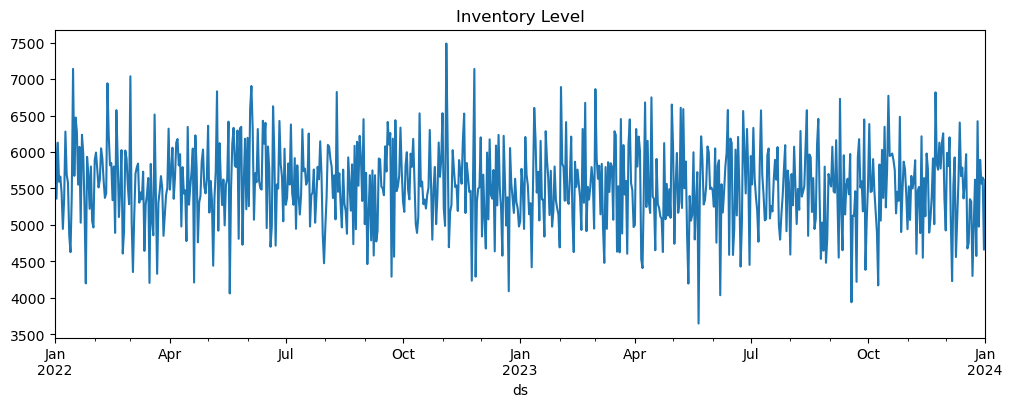

In [19]:
plt.figure(figsize=(12,4))
inv_data['y'].plot(title = 'Inventory Level')

#### Observations reveal deep seasonal patterns through date periods and severe spikes. Also, trend seems to be stable and neither getting incremented or reduced. 
#### Downward spikes indicate low inventory probably due to promotions or discounts, while upward spikes indicate overstock which might be due to reduced sales.

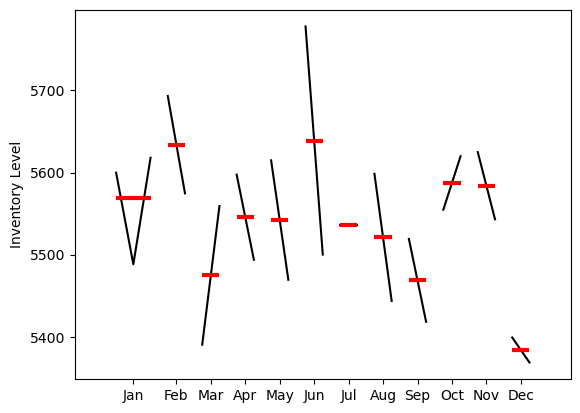

In [20]:
month_plot(inv_data['y'].resample('ME').mean(), ylabel='Inventory Level')
plt.show()

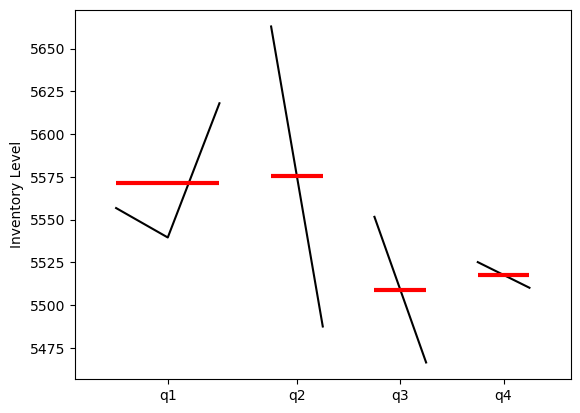

In [21]:
quarter_plot(inv_data['y'].resample('QE').mean(), ylabel='Inventory Level')
plt.show()

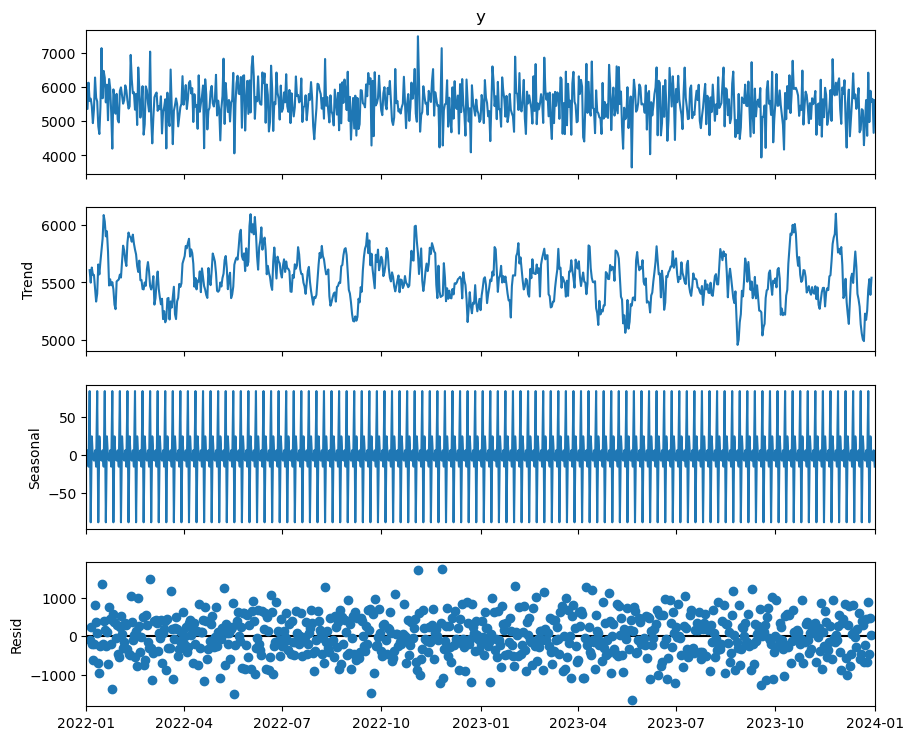

In [22]:
decomposition = seasonal_decompose(inv_data['y']  , model = 'add' , period = 7) 
fig = decomposition.plot()
fig.set_size_inches(10,8)
plt.show()

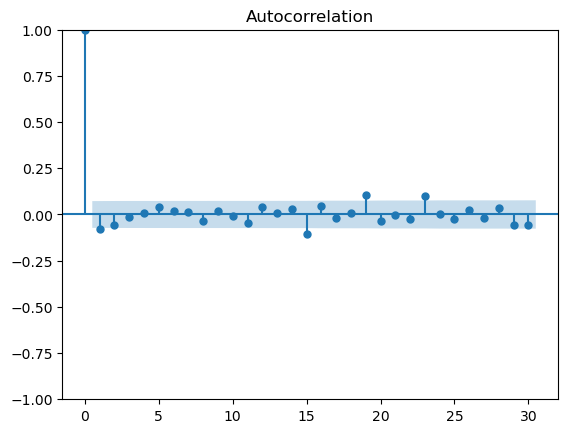

In [23]:
plot_acf(inv_data['y'] , lags = 30)
plt.show()

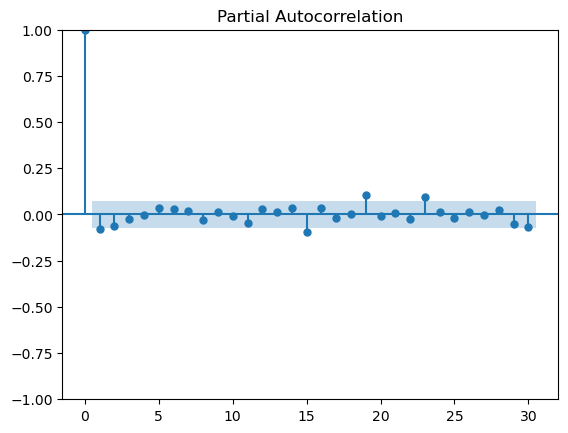

In [24]:
plot_pacf(inv_data['y'] , lags = 30)
plt.show()

 ## SARIMAX

In [25]:
result = adfuller(inv_data['y' ])
print( ' p-value : %f' % result[1])

if result[1] <0.05:
    print(' Evidence suggests that the time series is stationary')
else : 
    print(' Evidence suggests that the time series is not stationary')  

 p-value : 0.000000
 Evidence suggests that the time series is stationary


#### Since prerequisite of stationarity is satisfied, we proceed to modeling 

In [26]:
print('Our data confine :' ,inv_data.shape[0] , 'days')

Our data confine : 731 days


In [27]:
horizon = 60   # Forecast the next 60 days

train_target = inv_data['y'][:-horizon]
test_target = inv_data['y'][-horizon:]

train_exog = inv_data.drop(['y'] , axis=1)[:-horizon]
test_exog = inv_data.drop(['y'], axis=1)[-horizon:]

In [28]:
# Initiate Model 
sarimax = SARIMAX(endog=train_target , exog=train_exog , order= (1,0,1),
                  seasonal_order=(1,0,1,7) , enforce_stationarity = False)

model_fit = sarimax.fit()
print(model_fit.summary())

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                  671
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 7)   Log Likelihood               -4991.725
Date:                           Thu, 02 Oct 2025   AIC                          10017.450
Time:                                   19:28:45   BIC                          10093.870
Sample:                               01-01-2022   HQIC                         10047.067
                                    - 11-02-2023                                         
Covariance Type:                             opg                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Units Sold                  0.4141      0.466      0.889      0.374      -0.499       1.327
Unit

In [29]:
# Get the predictions 
sarimax_preds = model_fit.forecast(steps = horizon , exog = test_exog)

In [30]:
forecast_res = model_fit.get_forecast(steps=horizon, exog=test_exog)
pred_mean = forecast_res.predicted_mean        # forecast values
pred_ci = forecast_res.conf_int()              # lower & upper bounds

In [31]:
# Align forecast index with test_target
pred_mean.index = test_target.index
pred_ci.index = test_target.index

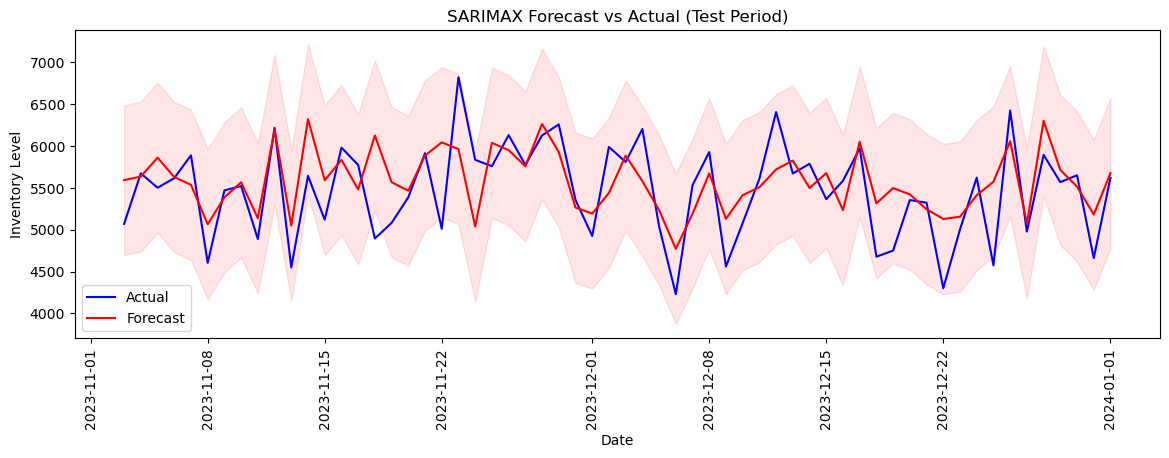

In [32]:
# Plot actual vs forecast
plt.figure(figsize=(14,4))
plt.plot(test_target.index, test_target, label='Actual', color='blue')
plt.plot(pred_mean.index, pred_mean, label='Forecast', color='red')
plt.fill_between(pred_ci.index, pred_ci.iloc[:,0], pred_ci.iloc[:,1], color='red', alpha=0.1)
plt.title('SARIMAX Forecast vs Actual (Test Period)')
plt.xlabel('Date')
plt.ylabel('Inventory Level')
plt.xticks(rotation=90)
plt.legend()
plt.show()

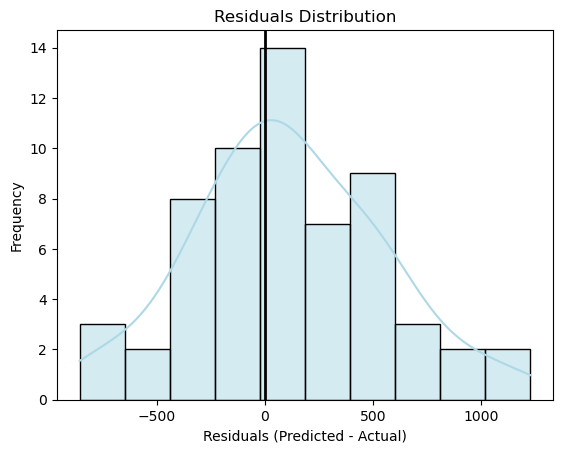

In [33]:
# Plot the residuals
sns.histplot(sarimax_preds - test_target, kde=True, bins=10, color="lightblue")
plt.title("Residuals Distribution")
plt.xlabel("Residuals (Predicted - Actual)")
plt.ylabel("Frequency")
plt.axvline(0, color='black', linestyle='-', linewidth=2)  # reference line at 0
plt.show()

In [34]:
rmse_sarimax = root_mean_squared_error(test_target , sarimax_preds)
mape_sarimax = mean_absolute_percentage_error(test_target, sarimax_preds) * 100
print(f"Sarimax - RMSE: {rmse_sarimax:.2f}")
print(f"Sarimax - MAPE: {mape_sarimax:.2f}%")

Sarimax - RMSE: 449.94
Sarimax - MAPE: 6.65%


## Prophet

In [35]:
from prophet import Prophet

In [36]:
df_prophet = inv_data.copy()

In [37]:
# Reset index since Prophet expects datetime and target columns seperately
df_prophet = inv_data.reset_index().rename(columns={'Date': 'ds'})

 ### Holiday Handling

In [38]:
df_prophet.head(2)

,ds,y,Units Sold,Units Ordered,Demand Forecast,Max_Discount,Max_Price,Holiday,Weather Condition_Rainy,Weather Condition_Snowy,Weather Condition_Sunny,Seasonality_Spring,Seasonality_Summer,Seasonality_Winter
0,2022-01-01,6115,3208,2202,3355.98,20,98.18,1,0,0,1,0,1,0
1,2022-01-02,5360,2236,2153,2365.58,20,97.74,0,0,0,0,0,0,0


In [39]:
df_prophet[df_prophet.Holiday==1].ds

0     2022-01-01
3     2022-01-04
4     2022-01-05
5     2022-01-06
6     2022-01-07
         ...    
720   2023-12-22
723   2023-12-25
724   2023-12-26
729   2023-12-31
730   2024-01-01
Name: ds, Length: 279, dtype: datetime64[ns]

#### We surmise that holidays/promotions occur only on the same day

In [40]:
holidays = pd.DataFrame({'holiday': 'promo_or_holiday',
                         'ds' : df_prophet[df_prophet.Holiday==1].ds,
                         'lower_window' : 0,
                         'upper_window' : 0 })

In [41]:
horizon = 60 

train = df_prophet.iloc[:-horizon]  
test = df_prophet.iloc[-horizon:]  

In [42]:
df_prophet.head(1)

,ds,y,Units Sold,Units Ordered,Demand Forecast,Max_Discount,Max_Price,Holiday,Weather Condition_Rainy,Weather Condition_Snowy,Weather Condition_Sunny,Seasonality_Spring,Seasonality_Summer,Seasonality_Winter
0,2022-01-01,6115,3208,2202,3355.98,20,98.18,1,0,0,1,0,1,0


In [43]:
df_prophet.columns

Index(['ds', 'y', 'Units Sold', 'Units Ordered', 'Demand Forecast',
       'Max_Discount', 'Max_Price', 'Holiday', 'Weather Condition_Rainy',
       'Weather Condition_Snowy', 'Weather Condition_Sunny',
       'Seasonality_Spring', 'Seasonality_Summer', 'Seasonality_Winter'],
      dtype='object')

In [44]:
# Initiate Prophet class 
prophet_model = Prophet(yearly_seasonality=True,weekly_seasonality=True,daily_seasonality=True,
                        holidays=holidays , seasonality_mode= 'additive',
                        seasonality_prior_scale=10, 
                        holidays_prior_scale=10,
                        changepoint_prior_scale=0.05) 

# Add exogenous variables one by one 
prophet_model.add_regressor('Units Sold')
prophet_model.add_regressor('Units Ordered')
prophet_model.add_regressor('Demand Forecast')
prophet_model.add_regressor('Max_Discount')
prophet_model.add_regressor('Max_Price')
prophet_model.add_regressor('Weather Condition_Rainy')
prophet_model.add_regressor('Weather Condition_Snowy')
prophet_model.add_regressor('Weather Condition_Sunny')
prophet_model.add_regressor('Seasonality_Spring')
prophet_model.add_regressor('Seasonality_Summer')
prophet_model.add_regressor('Seasonality_Winter')

prophet_model.fit(train)

19:28:46 - cmdstanpy - INFO - Chain [1] start processing
19:28:46 - cmdstanpy - INFO - Chain [1] done processing


In [45]:
from prophet.utilities import regressor_coefficients
regressor_coefficients(prophet_model)

,regressor,regressor_mode,center,coef_lower,coef,coef_upper
0,Units Sold,additive,2763.092399,0.461211,0.461211,0.461211
1,Units Ordered,additive,2199.652757,-0.027813,-0.027813,-0.027813
2,Demand Forecast,additive,2863.070373,0.251531,0.251531,0.251531
3,Max_Discount,additive,19.962742,-83.670268,-83.670268,-83.670268
4,Max_Price,additive,95.632265,5.368969,5.368969,5.368969
5,Weather Condition_Rainy,additive,0.000000,27.688078,27.688078,27.688078
6,Weather Condition_Snowy,additive,0.000000,-33.797612,-33.797612,-33.797612
7,Weather Condition_Sunny,additive,0.000000,61.100882,61.100882,61.100882
8,Seasonality_Spring,additive,0.000000,66.615195,66.615195,66.615195
9,Seasonality_Summer,additive,0.000000,109.591373,109.591373,109.591373


In [46]:
df_prophet.shape

(731, 14)

In [47]:
from prophet.diagnostics import cross_validation

prophet_cv = cross_validation(
    model=prophet_model,
    initial='500 days' ,    # training window (731-500-60)/30 ≈ 5 folds
    horizon='60 days',      # forecast horizon
    period='30 days',       # step between folds
    parallel='processes'
)

In [48]:
prophet_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2023-06-06,6701.091241,6133.099096,7252.298838,5886,2023-06-05
1,2023-06-07,4936.124682,4369.084981,5466.063174,4035,2023-06-05
2,2023-06-08,5813.051686,5243.278643,6377.544294,5557,2023-06-05
3,2023-06-09,5401.459912,4836.150967,5973.373981,5170,2023-06-05
4,2023-06-10,5370.538514,4812.520757,5975.859575,5448,2023-06-05


In [49]:
from prophet.diagnostics import performance_metrics
rmse = performance_metrics(prophet_cv)['rmse'].mean()
mape = performance_metrics(prophet_cv)['mape'].mean()*100
print(f"The RMSE is {rmse}")
print(f"The MAPE is {mape}")

The RMSE is 461.3120307995756
The MAPE is 6.907568192600287


 ### Parameter Tuning 

In [50]:
from sklearn.model_selection import ParameterSampler
from prophet.diagnostics import cross_validation, performance_metrics

# Define a Parameter Grid
param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.05, 0.1, 0.5 ,1.0],
    'seasonality_prior_scale': [1.0,2.0, 5.0, 10.0, 15.0, 20.0],
    'holidays_prior_scale': [1.0, 2.0, 5.0, 10.0],
    'seasonality_mode': ['additive', 'multiplicative']
}

all_params = list(ParameterSampler(param_grid, n_iter=30, random_state=42))
rmse_cv = []
for params in all_params:
    tune = Prophet(yearly_seasonality=True,weekly_seasonality=True,daily_seasonality=True,
               holidays=holidays, **params)
    
    tune.add_regressor('Units Sold')
    tune.add_regressor('Units Ordered')
    tune.add_regressor('Demand Forecast')
    tune.add_regressor('Max_Discount')
    tune.add_regressor('Max_Price')
    tune.add_regressor('Weather Condition_Rainy')
    tune.add_regressor('Weather Condition_Snowy')
    tune.add_regressor('Weather Condition_Sunny')
    tune.add_regressor('Seasonality_Spring')
    tune.add_regressor('Seasonality_Summer')
    tune.add_regressor('Seasonality_Winter')

    tune.fit(train)
    
    prophet_cv = cross_validation(
        model=tune,
        initial='500 days' ,    # training window (731-500-60)/30 ≈ 5 folds
        horizon='60 days',      # forecast horizon
        period='30 days',       # step between folds
        parallel='processes'
    )
    
    rmse = performance_metrics(prophet_cv)['rmse'].mean()
    rmse_cv.append(rmse)

19:28:48 - cmdstanpy - INFO - Chain [1] start processing
19:28:48 - cmdstanpy - INFO - Chain [1] done processing
19:28:51 - cmdstanpy - INFO - Chain [1] start processing
19:28:51 - cmdstanpy - INFO - Chain [1] done processing
19:28:54 - cmdstanpy - INFO - Chain [1] start processing
19:28:54 - cmdstanpy - INFO - Chain [1] done processing
19:28:57 - cmdstanpy - INFO - Chain [1] start processing
19:28:57 - cmdstanpy - INFO - Chain [1] done processing
19:29:00 - cmdstanpy - INFO - Chain [1] start processing
19:29:00 - cmdstanpy - INFO - Chain [1] done processing
19:29:03 - cmdstanpy - INFO - Chain [1] start processing
19:29:03 - cmdstanpy - INFO - Chain [1] done processing
19:29:05 - cmdstanpy - INFO - Chain [1] start processing
19:29:06 - cmdstanpy - INFO - Chain [1] done processing
19:29:08 - cmdstanpy - INFO - Chain [1] start processing
19:29:08 - cmdstanpy - INFO - Chain [1] done processing
19:29:11 - cmdstanpy - INFO - Chain [1] start processing
19:29:11 - cmdstanpy - INFO - Chain [1]

In [51]:
outcome = pd.DataFrame(all_params)
outcome['rmse_cv'] = rmse_cv
outcome = outcome.sort_values(by='rmse_cv')
outcome.head(1)

,seasonality_prior_scale,seasonality_mode,holidays_prior_scale,changepoint_prior_scale,rmse_cv
12,5.0,multiplicative,2.0,0.05,460.807469


In [52]:
tuned_model = Prophet(yearly_seasonality=True,weekly_seasonality=True,daily_seasonality=True,
                        holidays=holidays , seasonality_mode= 'multiplicative',
                        seasonality_prior_scale=5.0, 
                        holidays_prior_scale=2.0,
                        changepoint_prior_scale=0.05) 

tuned_model.add_regressor('Units Sold')
tuned_model.add_regressor('Units Ordered')
tuned_model.add_regressor('Demand Forecast')
tuned_model.add_regressor('Max_Discount')
tuned_model.add_regressor('Max_Price')
tuned_model.add_regressor('Weather Condition_Rainy')
tuned_model.add_regressor('Weather Condition_Snowy')
tuned_model.add_regressor('Weather Condition_Sunny')
tuned_model.add_regressor('Seasonality_Spring')
tuned_model.add_regressor('Seasonality_Summer')
tuned_model.add_regressor('Seasonality_Winter')

tuned_model.fit(train)

19:30:19 - cmdstanpy - INFO - Chain [1] start processing
19:30:19 - cmdstanpy - INFO - Chain [1] done processing


In [53]:
forecast = tuned_model.predict(test)

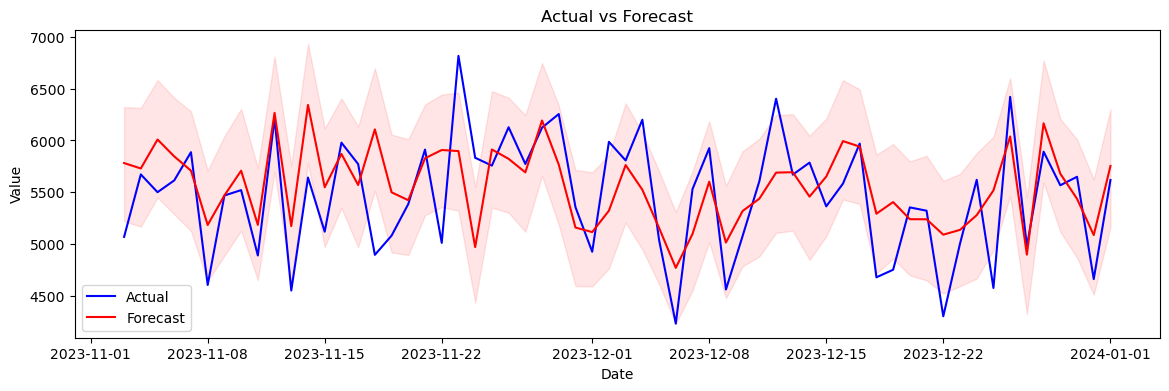

In [54]:
# Visualize forecasting
plt.figure(figsize=(14,4))
plt.plot(test['ds'] , test['y'] , label = 'Actual' , color = 'blue')
plt.plot(forecast['ds'] , forecast['yhat'] , label = 'Forecast' , color = 'red')
plt.fill_between(forecast['ds'] , forecast['yhat_lower'] , forecast['yhat_upper'] ,
                 color='red', alpha=0.1)
plt.title('Actual vs Forecast')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

In [55]:
# Align predictions with test period
forecast_test = forecast.set_index('ds').loc[test['ds']]
test_aligned = test.set_index('ds')

# Residuals = Actual - Predicted
residuals = test_aligned['y'] - forecast_test['yhat']

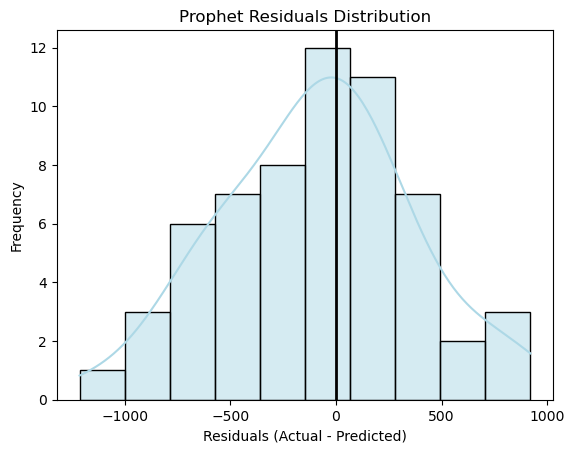

In [56]:
# Plot the residuals
sns.histplot(residuals, kde=True, bins=10, color="lightblue")
plt.title("Prophet Residuals Distribution")
plt.xlabel("Residuals (Actual - Predicted)")
plt.ylabel("Frequency")
plt.axvline(0, color='black', linestyle='-', linewidth=2)
plt.show()

In [57]:
y_true = test['y'].values      # actual values from test
y_pred = forecast['yhat'].values   # forecasted values

# RMSE
rmse_prophet = root_mean_squared_error(y_true, y_pred)

# MAPE
mape_prophet = mean_absolute_percentage_error(y_true, y_pred) * 100

print(f"Prophet - RMSE: {rmse_prophet:.2f}")
print(f"Prophet - MAPE: {mape_prophet:.2f}%")

Prophet - RMSE: 457.63
Prophet - MAPE: 6.81%


 # Inventory Analysis and Forecasting for Store S003

## 1. Data Aggregation

For Store **S003**, daily data was aggregated across products to ensure a single observation per day, suitable for time series modeling:

| Feature | Aggregation Method | Description |
|---------|-------------------|-------------|
| Inventory Level | Sum | Total inventory across all products (target) |
| Units Sold | Sum | Total daily sales |
| Units Ordered | Sum | Total daily orders |
| Demand Forecast | Sum | Total daily demand forecast |
| Discount | Max | Maximum discount applied to any product |
| Price | Max | Maximum price across products |
| Weather Condition | First | Non-null weather condition for the day |
| Seasonality | First | Non-null seasonality label |
| Holiday/Promotion | Mode | Most frequent holiday/promotion flag |

> This aggregation ensures that all relevant signals from sales, demand, promotions, and external conditions are preserved for analysis.

---

## 2. Exploratory Data Analysis (EDA)

### Seasonality of Inventory Levels

| Month | Inventory Level Trend |
|-------|-----------------------|
| JAN, APR, MAY, JUL, AUG, OCT, NOV | Stable: 5550–5600 units |
| MAR, SEP | Low inventory levels |
| DEC | Lowest inventory levels |
| FEB, JUN | Highest inventory levels |

- The series demonstrates **strong additive seasonality** and recurring trends.  
- Peaks in **February and June** align with seasonal cycles such as pre-spring and mid-year restocking, where demand is typically high.  
- The **December trough** corresponds to year-end sales and promotions, where high sales velocity reduces stock levels sharply.  
- Periods of stability (e.g., JAN, APR, MAY, JUL, AUG, OCT, NOV) suggest well-balanced supply and demand dynamics.

### Autocorrelation Analysis

- **Autocorrelation (ACF/PACF):** Most lags lie within the confidence intervals, with a few exceeding, indicating minor autocorrelation effects.  
- This suggests that inventory levels are primarily driven by seasonality and demand cycles, with limited unexplained temporal dependencies.

### Additional Insights

- **Promotions and Discounts:** Clear spikes and dips in inventory often coincide with promotional events, highlighting the importance of including **Holiday/Promotion** and **Discount** variables as exogenous factors.  
- **Price Effects:** Fluctuations in price levels show a measurable influence on demand, impacting both sales volume and inventory depletion rates.  
- **External Factors:** Weather conditions (e.g., rainy days) also introduce variation in demand, reinforcing the importance of including external regressors in the forecasting model.


---

## 3. SARIMAX Modeling

- **Target:** Daily inventory level  
- **Exogenous variables:** Units Sold, Units Ordered, Demand Forecast, Discount, Price, Weather Condition, Seasonality, Holiday/Promotion  
- **Model structure:** Seasonal ARIMA terms tuned to capture weekly and yearly cycles  

**Model Diagnostics:**

- Residuals are **approximately normally distributed around zero**  
- No significant autocorrelation or systematic bias detected  
- Model successfully captures both trend and seasonal dynamics  

**Forecast Performance:**

| Metric | Value |
|--------|-------|
| RMSE | 449.94 |
| MAPE | 6.65% |

> The SARIMAX model demonstrates strong predictive performance, providing reliable forecasts that are suitable for inventory planning and operational decision-making.

---

## 4. Prophet Modeling

- **Target:** Daily inventory level (`y`) with timestamps (`ds`)  
- **Additional regressors:** Units Sold, Units Ordered, Demand Forecast, Discount, Price, Weather Condition, Holiday/Promotion  
- **Strengths:** Flexible trend and seasonality decomposition, automatic handling of holiday/promotional effects, and intuitive interpretability  

**Model Diagnostics:**

- Residuals are **centered around zero** with no strong structure  
- Captures the deep seasonality and promotions-driven fluctuations effectively  
- Broader confidence intervals than SARIMAX, but highly interpretable components  

**Forecast Performance:**

| Metric | Value |
|--------|-------|
| RMSE | 457.63 |
| MAPE | 6.81% |

> The Prophet model performs comparably to SARIMAX, slightly less accurate but more interpretable with clear decomposition of trend, seasonality, and holiday effects.

---

## 5. Key Insights

- Inventory levels are **highly seasonal**, peaking in **FEB/JUN** and bottoming in **DEC**.  
- **Exogenous factors** such as sales, orders, discounts, and price significantly impact inventory dynamics.
  
### Model Comparison

| Model    | RMSE   | MAPE   | Strengths | Weaknesses |
|----------|--------|--------|-----------|-------------|
| SARIMAX  | 449.94 | 6.65%  | High accuracy, robust handling of trend and seasonality, strong statistical foundation | Less interpretable, requires parameter tuning , wider confidence intervals |
| Prophet  | 457.63 | 6.81%  | Intuitive, interpretable components (trend/seasonality/holidays), easy to incorporate regressors | Slightly lower accuracy compared to SARIMA |

Both models produce reliable forecasts with residuals behaving like random noise. **SARIMAX is recommended when accuracy is the priority**, while **Prophet is advantageous for interpretability and scenario analysis (e.g., holiday and promotion effects).**

**Conclusion:**  
Both SARIMAX and Prophet offer robust forecasting solutions for Store **S003**. SARIMAX is recommended when **accuracy** is the priority, while Prophet is advantageous when **interpretability and scenario analysis (e.g., holiday effects)** are required. Together, these approaches enable effective **inventory optimization**, helping balance supply with demand, reduce stockouts, and optimize holding costs.